https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset?resource=download 

In [ ]:
# !pip install flair
# from flair.data import Sentence
# from flair.nn import Classifier

# # make a sentence
# sentence = Sentence('I love Berlin .')

# # load the NER tagger
# tagger = Classifier.load('ner')

# # run NER over sentence
# tagger.predict(sentence)

# # print the sentence with all annotations
# print(sentence)

In [ ]:
# # make a sentence
# sentence = Sentence('The service was decent')

# # load the NER tagger
# tagger = Classifier.load('sentiment')

# # run NER over sentence
# tagger.predict(sentence)

# # print the sentence with all annotations
# print(sentence)

In [ ]:
# sentence = Sentence("Berlin is a strange place")
# tagger.predict(sentence)
# print(sentence)

In [ ]:
#!pip install --upgrade tensorflow

In [ ]:
import pandas as pd
#Importing necessary libraries for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

#Importing libraries necessary for Model Building and Training

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings('ignore')

# reading csv files
data =  pd.read_csv('spam.csv',encoding='ISO-8859-1')
print(data.columns)
data = data[["v1", "v2"]]
data = data.rename(columns={"v1": "spam_flg", "v2": "text"})

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data.loc[data["spam_flg"]=="ham","spam_flg"]=0
data.loc[data["spam_flg"]=="spam","spam_flg"]=1

print(len(data))
print(len(data[data["spam_flg"]==1]))
#possibly play with downsampling
not_spam = data[data["spam_flg"] == 0]
spam = data[data["spam_flg"] == 1]
#not_spam = not_spam.sample(n = len(spam), random_state=42)

# Plotting the counts of down sampled dataset
data = not_spam.append(spam).reset_index(drop = True)

print(len(data))
print(len(data[data["spam_flg"]==1]))

#THIS GRAPH IS BLATANTLY LYING SEABORN SUCKS
# plt.figure(figsize = (8, 6))
# sns.countplot(data.spam_flg)
# plt.title('Distribution of Ham and Spam email messages after downsampling')
# plt.xlabel('Message types')

#num_spaces_arr = data["text"].count(" ")
# print(data["text"].astype(str))
# num_spaces_arr = np.char.count(data["text"].astype(str), sub ='a')
# max_spaces = 0
#I'm an idiot with numpy theres got to be a way
# for t in data["text"]:
#   spaces = t.count(" ")
#   if spaces >max_spaces:
#     max_spaces = spaces
# max_words = max_spaces+1
# print(max_words)
max_words = 10000

5572
747
5572
747


In [ ]:
data[1000:1005]

,spam_flg,text
1000,0,To day class is there are no class.
1001,0,I'm in chennai velachery:)
1002,0,You flippin your shit yet?
1003,0,"K give me a sec, breaking a &lt;#&gt; at cstore"
1004,0,Am i that much bad to avoid like this?


In [ ]:
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)
 
data['text']= data['text'].apply(lambda x: remove_punctuations(x))

def remove_stopwords(text):
    stop_words = stopwords.words('english')
 
    imp_words = []
 
    # Storing the important words
    for word in str(text).split():
        word = word.lower()
 
        if word not in stop_words:
            imp_words.append(word)
 
    output = " ".join(imp_words)
 
    return output
 
 
data['text'] = data['text'].apply(lambda text: remove_stopwords(text))
data.head()


,spam_flg,text
0,0,go jurong point crazy available bugis n great ...
1,0,ok lar joking wif u oni
2,0,u dun say early hor u c already say
3,0,nah dont think goes usf lives around though
4,0,even brother like speak treat like aids patent


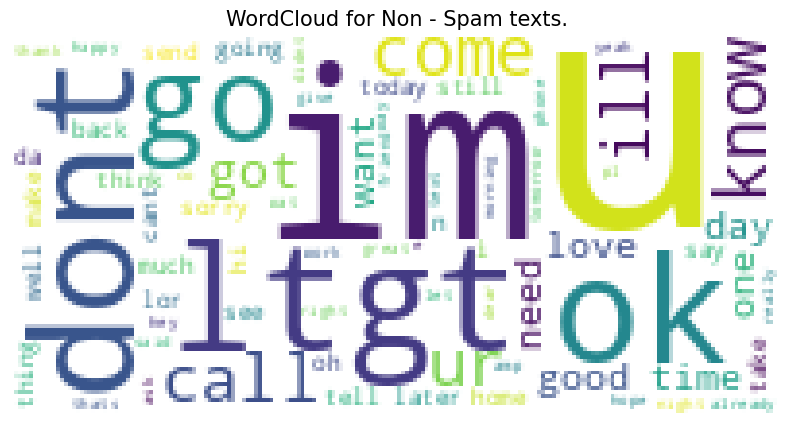

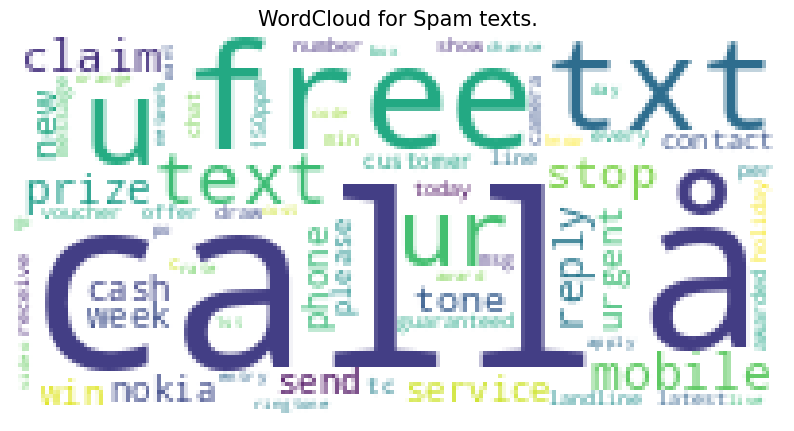

In [ ]:

def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text'])
    plt.figure(figsize=(10, 10))
    wc = WordCloud(background_color='white',
                   max_words=100,
                   width=200,
                   height=100,
                   collocations=False).generate(email_corpus)
 
    plt.title(f'WordCloud for {typ} texts.', fontsize=15)
    plt.axis('off')
    plt.imshow(wc)
    plt.show()
    print()
 
 
plot_word_cloud(data[data['spam_flg'] == 0], typ='Non - Spam')
plot_word_cloud(data[data['spam_flg'] == 1], typ='Spam')

In [ ]:

#train test split
train_X, test_X, train_Y, test_Y = train_test_split(data['text'],
                                                    data['spam_flg'],
                                                    test_size = 0.33,
                                                    random_state = 2)


In [ ]:
# training the tokenizer
token=Tokenizer()
token.fit_on_texts(train_X)
 
#Generating token embeddings
Training_seq = token.texts_to_sequences(train_X)
Training_pad = pad_sequences(Training_seq,
                             maxlen = 50,
                             padding = 'post',
                             truncating = 'post')
 
Testing_seq = token.texts_to_sequences(test_X)
Testing_pad = pad_sequences(Testing_seq,
                            maxlen = 50,
                            padding = 'post',
                            truncating = 'post')

In [ ]:
# Max words defined earlier, not sure what it does exactly. Seems like it cant be too small
# Building the Model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(max_words, 32,
                                    input_length=50))
model.add(tf.keras.layers.LSTM(4))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


In [ ]:

model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = ['accuracy'],
              optimizer = 'adam')

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
 
##IMPORTANT HYPERPARAMETERS PATIENCE
#Governs number of epochs, too soon seems underfitting, too long overfitting
es = EarlyStopping(patience= 20,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)
 
lr = ReduceLROnPlateau(patience = 20,
                       monitor = 'val_loss',
                       factor = 0.5,
                       verbose = 0)

In [ ]:
# history = model.fit(Training_pad.astype(float), train_Y.astype(float),
#                     validation_data = (Testing_pad.astype(float), test_Y.astype(float)),
#                     epochs = 30,
#                     verbose = 1,
#                     batch_size = 32,
#                     callbacks = [lr, es])

In [ ]:
#Epochs hyperparameter can tune model
history = model.fit(Training_pad.astype('float32'), train_Y.astype('float32'),
                    validation_data = (Testing_pad.astype('float32'), test_Y.astype('float32')),
                    epochs = 40,
                    verbose = 1,
                    batch_size = 32,
                    callbacks = [lr, es])

Epoch 1/40
117/117 [==============================] - 7s 37ms/step - loss: 0.4963 - accuracy: 0.8690 - val_loss: 0.4069 - val_accuracy: 0.8597 - lr: 0.0010
Epoch 2/40
117/117 [==============================] - 5s 39ms/step - loss: 0.3889 - accuracy: 0.8690 - val_loss: 0.4065 - val_accuracy: 0.8597 - lr: 0.0010
Epoch 3/40
117/117 [==============================] - 4s 30ms/step - loss: 0.3888 - accuracy: 0.8690 - val_loss: 0.4067 - val_accuracy: 0.8597 - lr: 0.0010
Epoch 4/40
117/117 [==============================] - 4s 30ms/step - loss: 0.3886 - accuracy: 0.8690 - val_loss: 0.4057 - val_accuracy: 0.8597 - lr: 0.0010
Epoch 5/40
117/117 [==============================] - 5s 39ms/step - loss: 0.3885 - accuracy: 0.8690 - val_loss: 0.4054 - val_accuracy: 0.8597 - lr: 0.0010
Epoch 6/40
117/117 [==============================] - 4s 31ms/step - loss: 0.3884 - accuracy: 0.8690 - val_loss: 0.4046 - val_accuracy: 0.8597 - lr: 0.0010
Epoch 7/40
117/117 [==============================] - 4s 30ms/st

In [ ]:
model.evaluate(Testing_pad.astype('float32'), test_Y.astype('float32'))


58/58 [==============================] - 0s 6ms/step - loss: 0.1287 - accuracy: 0.9799


[0.12867961823940277, 0.9798803925514221]

In [ ]:

len(data[data['spam_flg']==0])
len(data)
print(len(data[data['spam_flg']==0])/len(data))

0.8659368269921034


In [ ]:
y_pred = model.predict(Testing_pad.astype('float32')) >.5
np.unique(y_pred, return_counts=True)
print(test_Y.shape)
bools = y_pred.flatten()==test_Y
np.unique(bools, return_counts=True)

58/58 [==============================] - 1s 6ms/step
(1839,)


(array([False,  True]), array([  37, 1802]))

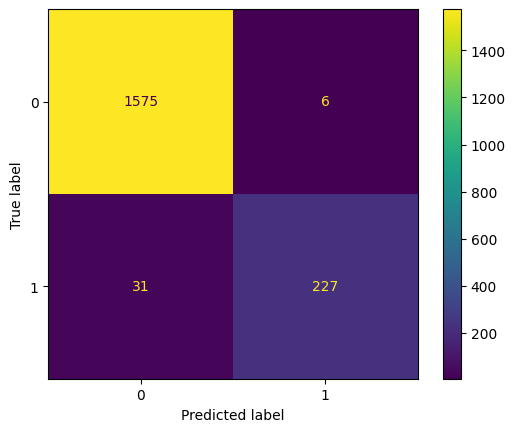

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(test_Y.astype(bool), y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot() 

In [ ]:
precision = 1575/(1575+6)
print(precision)
recall = 1575/(1575+31)
print(recall)

0.9962049335863378
0.9806973848069739
